<a href="https://colab.research.google.com/github/ujantechnologies/DO180-apps/blob/master/DC_Gan_using_tensorflow_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
import glob
import imageio
import re
import cv2

In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
!ls -lha /content/drive/MyDrive/Kaggle/kaggle.json

-rw------- 1 root root 64 Feb 25 20:13 /content/drive/MyDrive/Kaggle/kaggle.json


In [ ]:
!pip install -q kaggle
#!pip install h5py


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset


100% 1.33G/1.33G [01:00<00:00, 24.8MB/s]
100% 1.33G/1.33G [01:00<00:00, 23.7MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [ ]:
dataset  = keras.preprocessing.image_dataset_from_directory(
    directory ="/content/img_align_celeba",
    label_mode =None,
    image_size =(128,128),
    batch_size=32,
    shuffle= True
).map(lambda x :x/255.0)

Found 202599 files belonging to 1 classes.


In [ ]:
discriminator = keras.Sequential()
discriminator.add(keras.Input(shape=(128,128,3)))
discriminator.add(layers.Conv2D(64,kernel_size = 4, strides =2, padding ="same"))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Conv2D(128,kernel_size = 4, strides =2, padding ="same"))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Conv2D(128,kernel_size = 4, strides =2, padding ="same"))
discriminator.add(layers.LeakyReLU(0.2))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dropout(0.2))
discriminator.add(layers.Dense(1,activation="sigmoid"))

discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 flatten_6 (Flatten)         (None, 32768)           

In [ ]:
latent_dim = 128
generator = keras.Sequential()
generator.add(keras.Input(shape=(latent_dim,)))
generator.add(layers.Dense(8*8*128))
generator.add(layers.Reshape((8,8,128)))
generator.add(layers.Conv2DTranspose(128,kernel_size=4, strides=2, padding ="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(256,kernel_size=4, strides=2, padding ="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(512,kernel_size=4, strides=2, padding ="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2DTranspose(512,kernel_size=4, strides=2, padding ="same"))
generator.add(layers.LeakyReLU(0.2))
generator.add(layers.Conv2D(3,kernel_size = 5,  padding ="same",activation="sigmoid"))
generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_6 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_27 (Conv2  (None, 16, 16, 128)       262272    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_28 (Conv2  (None, 32, 32, 256)       524544    
 DTranspose)                                                     
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 32, 32, 256)     

In [ ]:
opt_gen = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
opt_disc = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
loss_fn = keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/GAN/CelebA/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = opt_gen,
                                 discriminator_optimizer = opt_disc,
                                 generator = generator,
                                 discriminator = discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoint)
  print('Latest checkpoint restored!')


In [ ]:
#generator =load_model('/content/drive/MyDrive/GAN/CelebA/training_checkpoints/generator.h5')
#discriminator = load_model('/content/drive/MyDrive/GAN/CelebA/training_checkpoints/discriminator.h5')
generator.load_weights('/content/drive/MyDrive/GAN/CelebA/training_checkpoints/generator.h5')
discriminator.load_weights('/content/drive/MyDrive/GAN/CelebA/training_checkpoints/discriminator.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 7 layers, found 5 saved layers.

In [ ]:
def getlatestnumber():
    filenames = glob.glob('/content/drive/MyDrive/GAN/CelebA/generated_high_image/generated_img_*.png')
    filenames = sorted(filenames)
    x=""
    for filename in filenames:
        x= filename
    match = re.search(r"(?<=_)\d+(?=_)", x)
    # Check if a match was found
    if match:
        # Extract the captured group (the number) and convert it to an integer
        number = int(match.group(0))
        return (number)  # Output: 1
    else:
        return (0)

In [ ]:
getlatestnumber()

0

In [ ]:
num_start = getlatestnumber()+1
num_start

1

In [ ]:
for epoch in range(9):
    for idx, real in enumerate (tqdm(dataset)):
        batch_size= real.shape[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size,latent_dim))
        fake = generator(random_latent_vectors)
        if (idx%1000 ==0):
            img = keras.preprocessing.image.array_to_img(fake[0])
            img.save(f"/content/drive/MyDrive/GAN/CelebA/generated_high_image/generated_img_{num_start}_{idx}.png")

        with tf.GradientTape() as disc_tape:
            loss_disc_real = loss_fn(tf.ones((batch_size,1)),discriminator(real))
            loss_disc_fake = loss_fn(tf.zeros((batch_size,1)),discriminator(fake))
            loss_disc = (loss_disc_real+loss_disc_fake)/2
        grads = disc_tape.gradient(loss_disc,discriminator.trainable_weights)
        opt_disc.apply_gradients(
            zip(grads,discriminator.trainable_weights)
        )
        with tf.GradientTape() as gen_tape:
            fake = generator(random_latent_vectors)
            output = discriminator(fake)
            loss_gen = loss_fn(tf.ones(batch_size,1),output)
        grads = gen_tape.gradient(loss_gen,generator.trainable_weights)
        opt_gen.apply_gradients(
            zip(grads,generator.trainable_weights)
        )
        if (idx)% 6000 == 0:
         #   checkpoint.save(file_prefix=checkpoint_prefix)
            generator.save_weights('/content/drive/MyDrive/GAN/CelebA/training_checkpoints/generatorh.h5')
            discriminator.save_weights('/content/drive/MyDrive/GAN/CelebA/training_checkpoints/discriminatorh.h5')
    num_start +=1




  0%|          | 0/6332 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
  1%|          | 37/6332 [01:35<4:30:59,  2.58s/it]


KeyboardInterrupt: 

In [ ]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I', format='GIF',duration=350 , loop=0) as writer:
  filenames = glob.glob('/content/drive/MyDrive/GAN/CelebA/generated_images/generated_img_*.png')
  filenames = sorted(filenames)
  for num, filename in enumerate(filenames):

    image = imageio.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    text = str(num)
    font_scale = .5  # Adjust for desired size
    font_thickness = 2  # Adjust for desired thickness
    color = (255, 0, 0)  # Change for desired color (BGR format)

    # Choose a location for the text
    text_location = (32, 55)  # Adjust coordinates as needed

    # Add the text to the image
    #cv2.putText(image, text, text_location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)


    writer.append_data(image)


<ipython-input-73-7e1fe77c2500>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:

from PIL import Image
# Create an empty list to store frames
frames = []
filenames = glob.glob('/content/drive/MyDrive/GAN/CelebA/generated_images/generated_img_*.png')
filenames = sorted(filenames)
for num, filename in enumerate(filenames):
    image = imageio.imread(filename)
    text = str(num)
    font_scale = .5  # Adjust for desired size
    font_thickness = 2  # Adjust for desired thickness
    color = (255, 0, 0)  # Change for desired color (BGR format)
    # Choose a location for the text
    text_location = (32, 55)  # Adjust coordinates as needed
    # Add the text to the image
    cv2.putText(image, text, text_location, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)
    # Save the modified image
    cv2.imwrite(filename, image)
    frame = Image.open(filename)
    frames.append(frame)
# Set animation duration (in milliseconds)
duration = 200  # Adjust as needed
# Create the GIF
gif = frames[0]  # Use the first frame as the base image
gif.save('looping_dcgan.gif', format='GIF', append_images=frames[1:], duration=duration, loop=0)  # Loop forever


<ipython-input-64-d2b108a36bd3>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
anim_file = 'celeb.gif'
with imageio.get_writer(anim_file, mode='I',duration =300, loop=0) as writer:
  filenames = glob.glob('/content/img_align_celeba/img_align_celeba/*.jpg')
  filenames = sorted(filenames)
  for x, filename in enumerate(filenames):
    image = imageio.imread(filename)
    writer.append_data(image)
    if x>=10:
        break

  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-103-2ed59abdf886>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-103-2ed59abdf886>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
filenames = glob.glob('/content/img_align_celeba/img_align_celeba/*.jpg')
filenames = sorted(filenames)
for x, filename in enumerate(filenames):
    image = imageio.imread(filename)
    print(image.shape)
    if x>=10:
        break

(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


<ipython-input-8-0cf1d8dc9c5e>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
anim_file1 = 'celebreshape.gif'
for idx, real in enumerate (tqdm(dataset)):
    #image = imageio.imread(real)
    #print(real.shape)
    with imageio.get_writer(anim_file1, mode='I',duration =300, loop =0 ) as writer:
        for i in range(32):
            img = keras.preprocessing.image.array_to_img(real[i])
            writer.append_data(img)

    if idx>=10:
        break

  0%|          | 10/6332 [00:08<1:29:03,  1.18it/s]


In [ ]:
!cp '/content/drive/MyDrive/GAN/CelebA/training_checkpoints/generator.h5' .
!cp '/content/drive/MyDrive/GAN/CelebA/training_checkpoints/discriminator.h5' .

In [ ]:
!rm -r '/content/drive/MyDrive/GAN/CelebA/training_checkpoints/'
!mkdir '/content/drive/MyDrive/GAN/CelebA/training_checkpoints/'


In [ ]:
!cp discriminator.h5 '/content/drive/MyDrive/GAN/CelebA/training_checkpoints/'
!cp generator.h5 '/content/drive/MyDrive/GAN/CelebA/training_checkpoints/'


In [ ]:
!rm -r '/content/drive/MyDrive/GAN/CelebA/generated_images'
!mkdir '/content/drive/MyDrive/GAN/CelebA/generated_images'


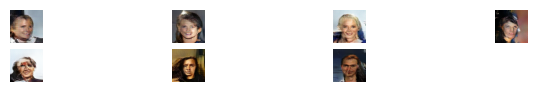

In [ ]:
random_latent_vectors = tf.random.normal(shape=(batch_size,latent_dim))
fake_batch = generator(random_latent_vectors)
fig = plt.figure(figsize=(8, 4))
for x in range(len(fake_batch)):
    img = keras.preprocessing.image.array_to_img(fake_batch[x])
    plt.subplot(8, 4, x+1)
    plt.imshow(img)
    plt.axis('off')
